In [1]:
from __future__ import division
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization, Input, Lambda, Reshape
from keras import backend as K
from keras.optimizers import SGD, Nadam
from keras import layers

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
%matplotlib inline

import os

Using TensorFlow backend.


In [2]:
DATA_DIR = os.path.abspath('./')
CHECKPOINTED_WEIGHTS = os.path.join(DATA_DIR, 'checkpointed_weights.hdf5')
INIT_WEIGHTS = os.path.join(DATA_DIR, 'init_weights_base.hdf5')
EXPERIENCE_BUFFER_FILE = os.path.join(DATA_DIR, 'experience_buffer.p')

In [121]:
from keras.layers.advanced_activations import LeakyReLU
from keras.regularizers import l2, l1
from keras.initializers import VarianceScaling

kernel_initializer = VarianceScaling(scale=0.001, mode='fan_avg', distribution='uniform', seed=42)

def dense_relu_bn_dropout(x, size, dropout, activation='relu', alpha = 0.1, reg = 0):
    x = Dense(size, kernel_regularizer = l2(reg), kernel_initializer=kernel_initializer)(x)
    x = Activation(activation)(x)
    x = Dropout(dropout)(x)
    return x

def create_network(reg, dropout, alpha = 0.1):
    inputs = Input(shape=(INPUT_SHAPE,), name="x")
    x = dense_relu_bn_dropout(inputs, size=8 , dropout=dropout, reg=reg)
    x = Dense(1, kernel_initializer=kernel_initializer)(x)
    base_network = Model(inputs=inputs, outputs = x)
    print(base_network.summary())
    return base_network

In [122]:
INPUT_SHAPE = 8
base_network = create_network(reg = 0.5, dropout = 0.5)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
x (InputLayer)               (None, 8)                 0         
_________________________________________________________________
dense_21 (Dense)             (None, 8)                 72        
_________________________________________________________________
activation_16 (Activation)   (None, 8)                 0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 8)                 0         
_________________________________________________________________
dense_22 (Dense)             (None, 1)                 9         
Total params: 81
Trainable params: 81
Non-trainable params: 0
_________________________________________________________________
None


In [123]:
BASE_WEIGHTS = base_network.get_weights()
for i in xrange(len(BASE_WEIGHTS)):
    if i == 0:
        BASE_WEIGHTS[i][:2, 0] = 1
    elif i == 2:
        BASE_WEIGHTS[i][0,0] = 1
for i, w in enumerate(BASE_WEIGHTS):
    print(i)
    print(w)

0
[[  1.00000000e+00   6.87097199e-03   1.14376266e-02   9.90638509e-03
   -9.31235030e-04   5.07418253e-03  -1.21603794e-02  -1.49377976e-02]
 [  1.00000000e+00   8.64972919e-03  -1.08753508e-02   1.38396267e-02
    1.25453826e-02   3.69531848e-03  -1.92501731e-02  -9.78878234e-03]
 [  2.35248357e-04  -5.36064617e-03  -1.76283326e-02   1.82869155e-02
    1.27184298e-02  -3.30814533e-03   3.93750705e-03  -6.21277466e-03]
 [  2.83125602e-03  -1.02147805e-02   6.76937588e-03  -1.90814082e-02
   -1.85549743e-02   1.78885218e-02   5.20928390e-03  -1.06005678e-02]
 [  5.86896390e-03   1.42149385e-02  -9.50662699e-03  -8.80788267e-03
   -1.36415288e-03  -8.05000495e-03  -1.12284468e-02  -2.86217965e-03]
 [  1.67792682e-02  -3.19867395e-03   8.32178630e-03   2.56576203e-03
   -7.71657284e-03   1.35459248e-02  -1.81600638e-03  -1.91971418e-02]
 [ -1.58476513e-02  -8.32168479e-03   9.55596752e-03   1.44553799e-02
   -3.28954495e-03   1.65057052e-02   2.64847092e-03  -3.64232622e-03]
 [  1.22314

In [124]:
base_network.set_weights(BASE_WEIGHTS)
base_network.get_weights()

[array([[  1.00000000e+00,   6.87097199e-03,   1.14376266e-02,
           9.90638509e-03,  -9.31235030e-04,   5.07418253e-03,
          -1.21603794e-02,  -1.49377976e-02],
        [  1.00000000e+00,   8.64972919e-03,  -1.08753508e-02,
           1.38396267e-02,   1.25453826e-02,   3.69531848e-03,
          -1.92501731e-02,  -9.78878234e-03],
        [  2.35248357e-04,  -5.36064617e-03,  -1.76283326e-02,
           1.82869155e-02,   1.27184298e-02,  -3.30814533e-03,
           3.93750705e-03,  -6.21277466e-03],
        [  2.83125602e-03,  -1.02147805e-02,   6.76937588e-03,
          -1.90814082e-02,  -1.85549743e-02,   1.78885218e-02,
           5.20928390e-03,  -1.06005678e-02],
        [  5.86896390e-03,   1.42149385e-02,  -9.50662699e-03,
          -8.80788267e-03,  -1.36415288e-03,  -8.05000495e-03,
          -1.12284468e-02,  -2.86217965e-03],
        [  1.67792682e-02,  -3.19867395e-03,   8.32178630e-03,
           2.56576203e-03,  -7.71657284e-03,   1.35459248e-02,
          -1.8

In [125]:
from keras import layers
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization, merge, Input, Lambda, Reshape

input_a = Input(shape=(INPUT_SHAPE,))
processed_a = base_network(input_a)
input_b = Input(shape=(INPUT_SHAPE,))
processed_b = base_network(input_b)
distance = layers.Subtract()([processed_a, processed_b])
out = Activation('sigmoid')(distance)
siamese_net = Model([input_a, input_b], out)
siamese_net.save_weights(INIT_WEIGHTS)
print(siamese_net.summary())

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_9 (InputLayer)             (None, 8)             0                                            
____________________________________________________________________________________________________
input_10 (InputLayer)            (None, 8)             0                                            
____________________________________________________________________________________________________
model_14 (Model)                 (None, 1)             81          input_9[0][0]                    
                                                                   input_10[0][0]                   
____________________________________________________________________________________________________
subtract_5 (Subtract)            (None, 1)             0           model_14[1][0]          

In [68]:
import cPickle as pickle
MOVES = pickle.load(open("../moves_dict.p", "rb"))

In [69]:
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
reduce_lr = ReduceLROnPlateau(monitor='val_acc', factor=0.5,
              patience=5, verbose = 1, min_lr=1e-8)
early_stopping = EarlyStopping(monitor='val_acc',
                              min_delta=5e-4,
                              patience=20,
                              verbose=0, mode='auto')
checkpointer = ModelCheckpoint(filepath=CHECKPOINTED_WEIGHTS, verbose=1, save_best_only=True, monitor='val_acc')

In [62]:
import utils; reload(utils)
from utils import DataGenerator

BATCH_SIZE = 512
maxlen = 4
EXPERIENCE_BUFFER_FILE = "experience_buffer/experience_buffer_len{}.p".format(maxlen) 
load_from_file = False #os.path.exists(EXPERIENCE_BUFFER_FILE)
save_to_file = not load_from_file
datagen = DataGenerator(MOVES, batch_sz = BATCH_SIZE, load_from_file = load_from_file, 
                 save_to_file = save_to_file, maxlen = maxlen, file = EXPERIENCE_BUFFER_FILE)

Experience buffer generated
Experience buffer saved to experience_buffer/experience_buffer_len4.p
Train: 1088350 Val: 45348


In [126]:
nadam = Nadam(lr=1e-3)
siamese_net.compile(optimizer=nadam, loss='binary_crossentropy', metrics=['accuracy'])
siamese_net.load_weights(INIT_WEIGHTS)

In [127]:
NUM_TRAIN_PAIRS, NUM_VAL_PAIRS = datagen.get_num_pairs()
STEPS_PER_EPOCH = NUM_TRAIN_PAIRS//BATCH_SIZE
VALIDATION_STEPS = NUM_VAL_PAIRS//BATCH_SIZE

In [ ]:
history = siamese_net.fit_generator(
        datagen.next_train(),
        steps_per_epoch=STEPS_PER_EPOCH,
        epochs=500,
        validation_data=datagen.next_val(),
        validation_steps=VALIDATION_STEPS,
        callbacks = [reduce_lr, checkpointer, early_stopping])

Epoch 1/500
2125/2125 [==============================] - 12s - loss: 1.4713 - acc: 0.6608 - val_loss: 0.5631 - val_acc: 0.7668
Epoch 2/500
2125/2125 [==============================] - 11s - loss: 0.6092 - acc: 0.6868 - val_loss: 0.5511 - val_acc: 0.7670
Epoch 3/500
2125/2125 [==============================] - 11s - loss: 0.6025 - acc: 0.6918 - val_loss: 0.5523 - val_acc: 0.7675
Epoch 4/500
2125/2125 [==============================] - 11s - loss: 0.6018 - acc: 0.6919 - val_loss: 0.5482 - val_acc: 0.7656
Epoch 5/500
2125/2125 [==============================] - 11s - loss: 0.6013 - acc: 0.6923 - val_loss: 0.5462 - val_acc: 0.7625
Epoch 6/500
2125/2125 [==============================] - 11s - loss: 0.6003 - acc: 0.6929 - val_loss: 0.5452 - val_acc: 0.7714
Epoch 7/500
2125/2125 [==============================] - 11s - loss: 0.6009 - acc: 0.6927 - val_loss: 0.5587 - val_acc: 0.7652
Epoch 8/500
2125/2125 [==============================] - 11s - loss: 0.6007 - acc: 0.6924 - val_loss: 0.5499 - 

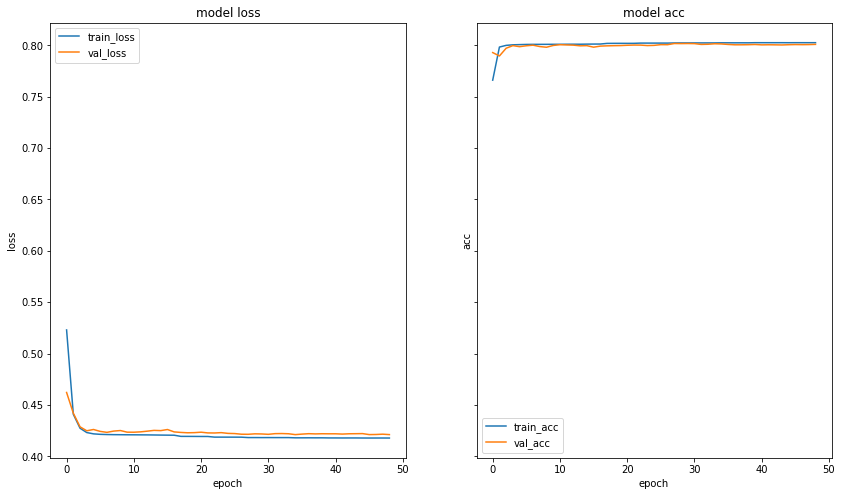

In [43]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
f.set_figheight(8)
f.set_figwidth(14)

ax1.plot(history.history['loss'])
ax1.plot(history.history['val_loss'])
ax1.set_title('model loss')
ax1.set_ylabel('loss')
ax1.set_xlabel('epoch')
ax1.legend(['train_loss', 'val_loss'], loc='upper left')

ax2.plot(history.history['acc'])
ax2.plot(history.history['val_acc'])
ax2.set_title('model acc')
ax2.set_ylabel('acc')
ax2.set_xlabel('epoch')
ax2.legend(['train_acc', 'val_acc'], loc='lower left')

plt.show()

In [72]:
for i in range(2):
    if i == 0:
        print("Base weights:")
        siamese_net.set_weights(BASE_WEIGHTS)
    else:
        print("Checkpointed weights:")
        siamese_net.load_weights(CHECKPOINTED_WEIGHTS)
    val = siamese_net.evaluate_generator(
            datagen.next_train(),
            steps=STEPS_PER_EPOCH)
    print("Loss: {} Acc: {}".format(val[0], val[1]))

Base weights:
Loss: 5.2614957908 Acc: 0.0485449120181
Checkpointed weights:
Loss: 7.28672732029 Acc: 0.177831625666


In [15]:
siamese_net.set_weights(BASE_WEIGHTS)
# siamese_net.load_weights(CHECKPOINTED_WEIGHTS)
SAVE_MODEL = "keras_tensorflow"
model_to_save = siamese_net.layers[2]
model_to_save.summary()
model_to_save.save(SAVE_MODEL, overwrite='True')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
x (InputLayer)               (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 36        
_________________________________________________________________
activation_1 (Activation)    (None, 4)                 0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 5         
Total params: 41
Trainable params: 41
Non-trainable params: 0
_________________________________________________________________


In [16]:
model_to_save.get_weights()

[array([[ 1.,  0.,  0.,  0.],
        [ 1.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.]], dtype=float32),
 array([ 0.,  0.,  0.,  0.], dtype=float32),
 array([[ 1.],
        [ 0.],
        [ 0.],
        [ 0.]], dtype=float32),
 array([ 0.], dtype=float32)]